In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from graphviz import Digraph
import networkx as nx


In [2]:
np.random.seed(1)
n = 1000

In [11]:
def draw_dag(edges, title):
    dot = Digraph(comment=title)
    for parent, child in edges:
        dot.edge(parent, child)
    display(dot)

First example - one confounder

In [8]:
draw_dag(
    edges=[
        ('Motivation', 'TrainingHours'),
        ('Motivation', 'Productivity'),
        ('TrainingHours', 'Productivity')
    ],
    title='Example 1;'
)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [28]:

motivation = np.random.normal(0, 1, n)
training_hours = 0.9 * motivation + np.random.normal(0, 2, n)
productivity = 5 * training_hours + 3 * motivation + np.random.normal(0, 1, n)

data1 = pd.DataFrame({
    'motivation': motivation,
    'training_hours': training_hours,
    'productivity': productivity
})

In [29]:
## without adjustment

print("Naive regression without adjustment:")
naive_model1 = smf.ols('productivity ~ training_hours', data=data1).fit()
print(naive_model1.summary())



Naive regression without adjustment:
                            OLS Regression Results                            
Dep. Variable:           productivity   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.536e+04
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:45:16   Log-Likelihood:                -2530.2
No. Observations:                1000   AIC:                             5064.
Df Residuals:                     998   BIC:                             5074.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Interce

In [30]:
## with adjustment

print("Regression with adjustment for motivation:")
model1 = smf.ols('productivity ~ motivation + training_hours', data=data1).fit()
print(model1.summary())

Regression with adjustment for motivation:
                            OLS Regression Results                            
Dep. Variable:           productivity   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 7.503e+04
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:45:18   Log-Likelihood:                -1418.2
No. Observations:                1000   AIC:                             2842.
Df Residuals:                     997   BIC:                             2857.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
I

Second example - two variable

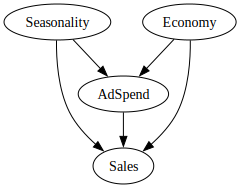

In [31]:
draw_dag(
    edges=[
        ('Seasonality', 'AdSpend'),
        ('Economy', 'AdSpend'),
        ('Seasonality', 'Sales'),
        ('Economy', 'Sales'),
        ('AdSpend', 'Sales')
    ],
    title='Seasonality & Economy → AdSpend → Sales'
)


In [32]:

seasonality = np.random.normal(0, 1, n)
economy = np.random.normal(0, 1, n)
ad_spend = 0.6 * seasonality + 0.4 * economy + np.random.normal(0, 1, n)
sales = 3.0 * ad_spend + 1.0 * seasonality + 0.5 * economy + np.random.normal(0, 1, n)

data2 = pd.DataFrame({
    'seasonality': seasonality,
    'economy': economy,
    'ad_spend': ad_spend,
    'sales': sales
})

In [35]:

## Naive (unadjusted) regression — violates Backdoor Criterion
naive_model2 = smf.ols('sales ~ ad_spend', data=data2).fit()
print("Unadjusted model:")
print(naive_model2.summary())



Unadjusted model:
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     9845.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:48:09   Log-Likelihood:                -1749.4
No. Observations:                1000   AIC:                             3503.
Df Residuals:                     998   BIC:                             3513.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0385      0.044  

In [36]:
## Adjusted regression — satisfies Backdoor Criterion by controlling for seasonality and economy
model2 = smf.ols('sales ~ ad_spend + seasonality + economy', data=data2).fit()
print("\nAdjusted model:")
print(model2.summary())



Adjusted model:
                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     6949.
Date:                Thu, 26 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:48:14   Log-Likelihood:                -1398.2
No. Observations:                1000   AIC:                             2804.
Df Residuals:                     996   BIC:                             2824.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0067      0.031

Third example - collider

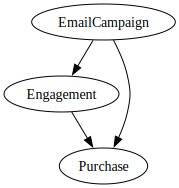

In [42]:
draw_dag(
    edges=[
        ('EmailCampaign', 'Engagement'),
        ('Engagement', 'Purchase'),
        ('EmailCampaign', 'Purchase')
    ],
    title='Example 3; Email Campaign → Engagement → Purchase (with direct effect'
)


In [6]:
n = 1000
email = np.random.binomial(1, 0.5, n)
engagement = 0.8 * email + np.random.normal(0, 1, n)
purchase = 1.2 * engagement + 0.5 * email + np.random.normal(0, 1, n)

data3= pd.DataFrame({
    'email': email,
    'engagement': engagement,
    'purchase': purchase
})

In [9]:

## Adjusted regression
model3 = smf.ols('purchase ~ email + engagement', data=data3).fit()
print("Adjusted model:")
print(model3.summary())



Adjusted model:
                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     912.0
Date:                Tue, 01 Jul 2025   Prob (F-statistic):          6.71e-226
Time:                        19:15:45   Log-Likelihood:                -1414.9
No. Observations:                1000   AIC:                             2836.
Df Residuals:                     997   BIC:                             2851.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0238      0.046    

In [11]:

## Non-adjusted regression 
model3 = smf.ols('purchase ~  email', data=data3).fit()
print("Unadjusted model:")
print(model3.summary())



Unadjusted model:
                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     190.0
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           1.05e-39
Time:                        19:49:07   Log-Likelihood:                -1847.8
No. Observations:                1000   AIC:                             3700.
Df Residuals:                     998   BIC:                             3709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1173      0.071  

Fourth example - mediator

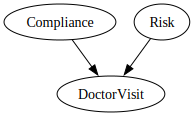

In [52]:
draw_dag(
    edges=[
        ('Compliance', 'DoctorVisit'),
        ('Risk', 'DoctorVisit')
    ],
    title='Compliance → DoctorVisit ← Risk'
)


In [48]:
n = 1000

compliance = np.random.binomial(1, 0.5, n)

risk = np.random.normal(0, 1, n)

doctor_visit = 0.8 * compliance + 0.8 * risk + np.random.normal(0, 1, n)

data4= pd.DataFrame({
    "compliance": compliance,
    "risk": risk,
    "doctor_visit": doctor_visit
})

In [ ]:

## Incorrect model (adjusts for collider):

naive_model4 = smf.ols('risk ~ compliance + doctor_visit', data=data4).fit()
print(naive_model4.summary())

                            OLS Regression Results                            
Dep. Variable:                   risk   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     328.1
Date:                Thu, 26 Jun 2025   Prob (F-statistic):          3.18e-110
Time:                        20:02:56   Log-Likelihood:                -1167.3
No. Observations:                1000   AIC:                             2341.
Df Residuals:                     997   BIC:                             2355.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0003      0.035     -0.007   

In [ ]:

## Correct model (does not adjust for collider and there's close to no association between compliance and risk):

model4 = smf.ols('risk ~ compliance', data=data4).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                   risk   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09296
Date:                Thu, 26 Jun 2025   Prob (F-statistic):              0.761
Time:                        20:03:43   Log-Likelihood:                -1420.1
No. Observations:                1000   AIC:                             2844.
Df Residuals:                     998   BIC:                             2854.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0339      0.045      0.750      0.4